### Data Load

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(0)
torch.manual_seed(0)

In [40]:
gs = pd.read_csv('gs_boo.csv', encoding = 'EUC-KR')
gs

In [41]:
gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   회사명       39 non-null     object 
 1   거래소코드     39 non-null     int64  
 2   회계년도      39 non-null     object 
 3   자산총계      39 non-null     int64  
 4   부채총계      39 non-null     int64  
 5   자본총계      39 non-null     int64  
 6   매출액       39 non-null     int64  
 7   매출원가      39 non-null     int64  
 8   매출총이익     39 non-null     int64  
 9   판매비와 관리비  39 non-null     int64  
 10  영업이익      39 non-null     int64  
 11  당기순이익     39 non-null     int64  
 12  r         39 non-null     float64
 13  i         39 non-null     float64
 14  영업이익r     39 non-null     int64  
 15  영업이익i     39 non-null     int64  
dtypes: float64(2), int64(12), object(2)
memory usage: 5.0+ KB


C:\Users\AHR\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\AHR\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


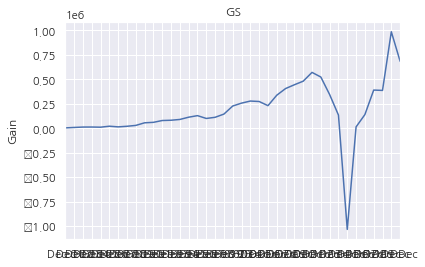

In [60]:
x = gs['회계년도']
plt.title('GS')
plt.ylabel('Gain')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x,gs['영업이익'])
plt.show()

## LSTM + F.C

### Data_setting

In [5]:
def data_setting(df):
    df = df.values.astype(float)

    test_data_size = 1
    train_data = df[:-test_data_size]
    test_data = df[-test_data_size:]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    
    train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
    train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
    
    return train_data_normalized, test_data, scaler

### Create_inout_sequences
in : train_data_normalized, feature_window, period
1. LSTM에 들어갈 input data를 데이터 주기와 피쳐수를 기반으로 sequence를 생성

out : sequence

In [6]:
def create_inout_sequences(input_data, fw, period):
    inout_seq = []
    L = len(input_data)
    
    for i in range(0, L-period*fw, fw):
        train_seq = input_data[i:i+period*fw]
        train_label = input_data[i+(period+1)*fw-1:i+(period+1)*fw]
        inout_seq.append((train_seq ,train_label))
        
    return inout_seq

### LSTM+F.C

In [7]:
class LSTM(nn.Module):
    
    def __init__(self, fw, period, layers, hidden_layer_size = 250, output_size = 1):
        super().__init__()
        self.input_size = fw
        self.hidden_layer_size = hidden_layer_size
        self.output_size = output_size
        self.period = period
        self.layers = layers


        self.lstm = nn.LSTM(self.input_size, self.hidden_layer_size, num_layers = layers)

        self.linear = nn.Sequential(
            nn.Linear(hidden_layer_size, 50),
            nn.Linear(50, self.output_size)
        )

        self.hidden_cell = (torch.zeros(layers,period,hidden_layer_size),
                       torch.zeros(layers,period,hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(-1 ,self.period, self.input_size), self.hidden_cell) 
        predictions = self.linear(lstm_out.view(self.period, self.hidden_layer_size))
        return predictions[-self.output_size:]

In [8]:
train_window = 3
period = 4
learning_rate = 0.01
layers = 3

In [9]:
df = gs.loc[:,['유동자산', '매출총이익', '영업이익']]
train_data_normalized,test_data,scaler = data_setting(df)
train_inout_seq = create_inout_sequences(train_data_normalized, train_window, period)

In [10]:
model = LSTM(train_window,period, layers)

In [11]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 500

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        y_pred = model(seq)[0]
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.06352742
epoch:  26 loss: 0.03877692
epoch:  51 loss: 0.03771861
epoch:  76 loss: 0.05092982
epoch: 101 loss: 0.01982546
epoch: 126 loss: 0.02223150
epoch: 151 loss: 0.02259693
epoch: 176 loss: 0.02177601
epoch: 201 loss: 0.02214283
epoch: 226 loss: 0.02248850
epoch: 251 loss: 0.02994714
epoch: 276 loss: 0.03225714
epoch: 301 loss: 0.03794438
epoch: 326 loss: 0.02255433
epoch: 351 loss: 0.03065403
epoch: 376 loss: 0.04117944
epoch: 401 loss: 0.02281314
epoch: 426 loss: 0.02220714
epoch: 451 loss: 0.02256430
epoch: 476 loss: 0.03326921
epoch: 499 loss: 0.0281095952


In [12]:
fut_pred = 1
test_inputs = train_data_normalized[-period*train_window:].tolist()

In [13]:
len(test_inputs)

3

In [14]:
model(seq)

tensor([[-0.7577]], grad_fn=<SliceBackward>)

In [15]:
model.eval()

for i in [1]:
    seq = torch.FloatTensor(test_inputs[-period*train_window:])
    pred = model(seq)
    with torch.no_grad():
        test_inputs.append(float(model(seq)[-1]))

In [16]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[-fut_pred:]).reshape(-1, 1))
ans = gs['영업이익'][-5:]

In [17]:
actual_predictions[0]

array([154106.09422773])

In [18]:
ans[-1:]

38    680931
Name: 영업이익, dtype: int64

In [19]:
RMSE = mean_squared_error(ans[-1:],actual_predictions[0])**0.5

In [20]:
RMSE

526824.9057722688